# Tutorial 02: Designing an Adversary

Continuing from Tutorial 1 Part 2, we are interested in attacks on Networks. But for an attack to be executed, a model is needed for how attacking vehicles should behave. The attack vehicle from Tutorial 1 used a specific controller, `ACC_Switched_Controller_Attacked_Single`. But in Flow/Anti-Flow the behavior of an attack vehicle can be even more fine-tuned by the `controller` class in Flow, which specifies different components for how vehicles drive. 

By defining a new acceleration controller based on the `controller` class in Flow, we can specify how an attacking vehicle should behave. In Part 1 of this tutorial we present the architecture for writing a normal car-following controller. In Part 2 we implement a simple adversarial controller, which we then simulate attacking a traffic flow.

---

## 1. Basic Car Following Controller

Let's start with a car-following controller. The car-following controller dictates how a car moves longitudinally, and in Anti-Flow/Flow are typically acceleration based ordinary differential equations (ODEs). In the traffic literature these are commonly referred to as car-following models (CFMs). A good overview of CFMs can be found at [1]. First, we're going to design a 'normal' cfm, representing a non-attacked vehicle, which uses the popular 'Bando Optimal-velocity Follow-the-leader' model [2]. In general, models for vehicular motion in Anti-Flow/Flow inherit the BaseController class. Here, we implement an instance of this controller specifically for performing car following:

In [1]:
# First, import a Base Controller which other controllers will inherit from:
import numpy as np
from Adversaries.controllers.base_controller import BaseController

class cfm_non_adversarial(BaseController):
    def __init__(self,
                 veh_id,
                 car_following_params,
                 delay=0.0,
                 noise=0.0,
                 fail_safe=None,
                 a=0.8,
                 b=20.0,
                 s0=1.0,
                 s1=2.0,
                 Vm=15.0):
        # Inherit the base controller:
        BaseController.__init__(
            self,
            veh_id,
            car_following_params,
            delay=delay,
            fail_safe=fail_safe,
            noise=noise)
        
        # Model parameters, which can be changed at initialization:
        self.Vm = Vm
        self.s0 = s0
        self.s1 = s1
        self.a = a
        self.b = b
        
    def get_accel(self, env):
        """This function is queried during simulation
           to acquire an acceleration value:"""
        # env contains all information on the simulation, and 
        # can be queried to get the state of different vehicles.
        # We assume this vehicle has access only to its own state,
        # and the position/speed of the vehicle ahead of it. 
        lead_id = env.k.vehicle.get_leader(self.veh_id) # Identify leader
        v_l = env.k.vehicle.get_speed(lead_id) # Leader speed
        v = env.k.vehicle.get_speed(self.veh_id) # vehicle's own speed
        s = env.k.vehicle.get_headway(self.veh_id) # inter-vehicle spacing to leader

        # We build this model off the popular Bando OV-FTL model:
        v_opt = self.OV(s)
        ftl = self.FTL(v,v_l,s)
        u = self.a*(v_opt-v) + self.b*ftl
        
        return u # return the acceleration that is set above.
        
    def get_custom_accel(self, v, v_l, s):
        """This function can be queried at any time,
           and is useful for analyzing controller
           behavior outside of a sim."""
        v_opt = self.OV(s)
        ftl = self.FTL(v,v_l,s)
        u = self.a*(v_opt-v) + self.b*ftl
        return u
    
    def OV(self,s):
        return self.Vm*((np.tanh(s/self.s0-self.s1)+np.tanh(self.s1))/(1+np.tanh(self.s1)))
    
    def FTL(self,v,v_l,s):
        return (v_l-v)/(s**2)
    
print('Non adversarial CFM initialized.')

Non adversarial CFM initialized.


The two main components needed for this controller are `get_accel()`, which is called within the Flow simulation to advance the motion of vehicles, and `get_custom_accel()`, which should reflect the same model as `get_accel()`, but accepts generic inputs, rather than the state of the simulation (env). Additionally, we added the functions `OV(s)` and `FTL(v,v_l,s)` that make up Bando-FTL model. Let's instantiate an instance of this controller and look at the OV function, which tells us what speed the cfm tries to drive at given a certain spacing difference :

Text(0.5, 1.0, 'Optimal velocity values')

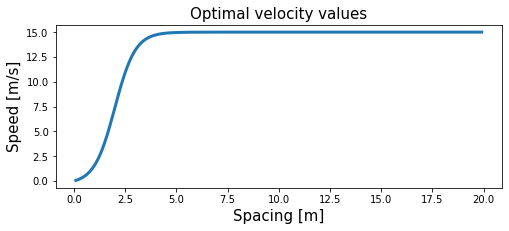

In [2]:
import matplotlib.pyplot as plt
from flow.core.params import SumoCarFollowingParams  # Needed to instantiate a car following model:

car_following_params = SumoCarFollowingParams()

# Initialize the CFM:
cfm = cfm_non_adversarial('cfm_non_adv_0',# Specify a veh_id
                          car_following_params)

s_vals = np.arange(0.1,20.0,0.1) # Specify a set of spacing values
v_vals = np.zeros_like(s_vals) # What OV(s) will return

for i in range(len(s_vals)):
    v_vals[i] = cfm.OV(s_vals[i]) # query the cfm
    
#Plot results:
plt.figure(figsize = [8,3])
plt.plot(s_vals,v_vals,linewidth=3)
plt.ylabel('Speed [m/s]',fontsize=15)
plt.xlabel('Spacing [m]',fontsize=15)
plt.title('Optimal velocity values',fontsize=15)

Let's now initialize and run a simulation on the ring-road to check the behavior of this model. We encourage you to experiment with changing the structure of the proposed CFM. 

In [3]:
#Import different needed quantities:
from flow.core.params import VehicleParams
from flow.controllers.routing_controllers import ContinuousRouter #Router that keeps vehicles on the ring-road
from flow.networks.ring import ADDITIONAL_NET_PARAMS
from flow.core.params import NetParams
from flow.core.params import InitialConfig
from flow.core.params import TrafficLightParams
from flow.networks.ring import RingNetwork
from flow.core.params import SumoParams
from flow.envs.ring.accel import AccelEnv
from flow.envs.ring.accel import ADDITIONAL_ENV_PARAMS
from flow.core.params import EnvParams
from flow.core.experiment import Experiment

#Initialize simulation environemnt:
time_step = 0.1 #In seconds, how far each step of the simulation goes.
want_render = True #If we want SUMO to render the environment and display the simulation.
emission_path = 'data' #Where

initial_config = InitialConfig(spacing="uniform", perturbation=1) # Vehicles start out evenly spaced.
traffic_lights = TrafficLightParams() # This is empty, so no traffic lights are used.
sim_params = SumoParams(sim_step=time_step, render=want_render, emission_path=emission_path) #Sets the simulation time-step and where data will be recorded.
env_params = EnvParams(additional_params=ADDITIONAL_ENV_PARAMS)
net_params = NetParams(additional_params={'length': 300,
                                          'lanes': 1,
                                          'speed_limit': 30,
                                          'resolution': 40})

vehicles = VehicleParams()
#Specify how human driven vehicles will drive:
num_human_drivers = 25
# Define a driver model human drivers:
vehicles.add("human",
             acceleration_controller=(cfm_non_adversarial, {'noise':0.05}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=num_human_drivers)

#initialize the simulation:
flow_params = dict(
    exp_tag='ring_no_attack',
    veh=vehicles,
    net=net_params,
    initial=initial_config,
    tls=traffic_lights,
    network=RingNetwork,
    simulator='traci',
    sim=sim_params,
    env_name=AccelEnv,
    env=env_params
)

# number of time steps
sim_horizon = 3000 # How many simulation steps will be taken -> Runs for 300 seconds
flow_params['env'].horizon = sim_horizon
exp = Experiment(flow_params)

print('Simulation ready.')

Simulation ready.


Run the simulation. Above render is set to False, so the GUI will not appear. Set to True to watch the simulation in SUMO.

In [4]:
# Run the simulation and save the data:
sim_res_list_no_attack = exp.run(1, convert_to_csv=True)
print('Simulation finished.')

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 1346.612317157993
data/ring_no_attack_20220711-1628521657574932.5027132-0_emission.csv data
Average, std velocities: 4.489705283235585, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 1346.612317157993, 0.0
Total time: 33.097525119781494
steps/second: 126.4868786524717
Simulation finished.


Data loaded.


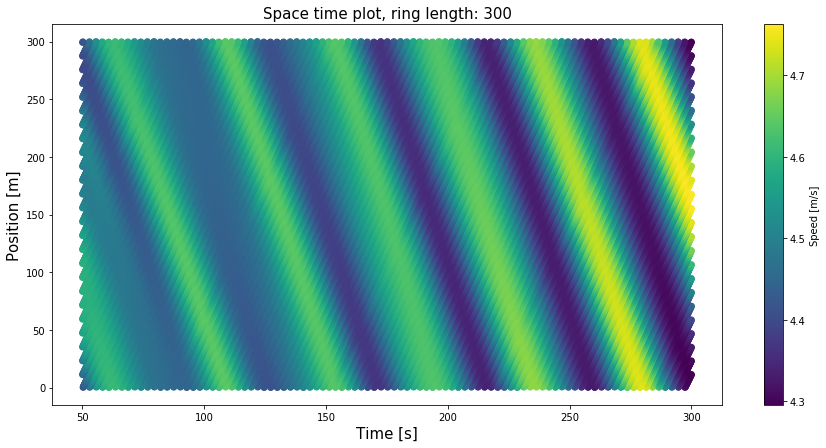

In [10]:
import os
import flow.visualize.visualize_ring as visualize_ring
emission_location = os.path.join(os.getcwd(),sim_res_list_no_attack[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_location)

Now, let's define a new controller which is adversarial in nature. Again, get_accel() and get_custom_accel() should be specified. This time however, the compromised AV will attempt to introduce larger oscillations into the traffic by overreacting to drawing too close to a vehicle in front of it.

In [5]:
class cfm_adversarial(BaseController):
    def __init__(self,
                 veh_id,
                 car_following_params,
                 delay=0.0,
                 noise=0.0,
                 fail_safe=None,
                 v_des=10.0):
        #Inherit the base controller:
        BaseController.__init__(
            self,
            veh_id,
            car_following_params,
            delay=delay,
            fail_safe=fail_safe,
            noise=noise)
        
        self.braking_period = 5.0 #How long the mAV brakes for
        self.braking_rate = -2.0 #How hard the mAV brakes
        self.curr_braking_period = 0.0 #Keeps track of braking
        self.is_braking = False #Whether or not engaged in braking
        self.v_des = v_des #If not braking, what speed the mAV tries to drive at
                
    def get_accel(self, env):
        lead_id = env.k.vehicle.get_leader(self.veh_id) #Who is the leader
        v_l = env.k.vehicle.get_speed(lead_id) #Leader speed
        v = env.k.vehicle.get_speed(self.veh_id) #vehicle's own speed
        s = env.k.vehicle.get_headway(self.veh_id) #inter-vehicle spacing to leader
        u = 0.0
        
        #If the vehicle gets too close it brakes for a long period of time:
        if(s < 10.0):
            self.is_braking = True

        #Engaged in braking:    
        if(self.is_braking):
            u = self.braking_rate
            self.curr_braking_period += env.sim_step
            if(self.curr_braking_period>=self.braking_period):
                self.curr_braking_period = 0.0
                self.is_braking = False
                
        #Managin speed:
        else:
            u = 0.1*(self.v_des - v) #Simple proportional speed control
            
        return u #return the acceleration that is set above.
        
    def get_custom_accel(self, v, v_l, s):
        """Leave as 0.0 since behavior has memory"""
        return 0.0
    
    print('Adversarial AV initialized.')

Adversarial AV initialized.


Let's now re-initialize and reun the simulation, this time with the adversarial agent introduced. In general this AV drives 'sensibly' in that it slows down in response to being close to another vehicle, and otherwise tries to maintain a certain speed, but the response is exagerated and will affect the overall traffic performance.

In [6]:
vehicles = VehicleParams()

num_human_drivers = 24
# Define a driver model human drivers:
vehicles.add(veh_id="human",
             acceleration_controller=(cfm_non_adversarial, {'noise':0.05}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=num_human_drivers)

vehicles.add(veh_id="Adv_AV",
             color="red", #Let's make the adversary red
             acceleration_controller=(cfm_adversarial, {}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=1)

#initialize the simulation:
flow_params = dict(
    exp_tag='ring_with_attack',
    env_name=AccelEnv,
    network=RingNetwork,
    simulator='traci',
    sim=sim_params,
    env=env_params,
    net=net_params,
    veh=vehicles,
    initial=initial_config,
    tls=traffic_lights,
)

# number of time steps
flow_params['env'].horizon = sim_horizon
exp = Experiment(flow_params)
print('Simulation ready.')

Simulation ready.


In [7]:
#Run the simulation and save the data:
sim_res_list_with_attack = exp.run(1, convert_to_csv=True)
print('Simulation finished.')

/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 952.9920074440103
data/ring_with_attack_20220711-1629441657574984.840317-0_emission.csv data
Average, std velocities: 3.795893655917715, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 952.9920074440103, 0.0
Total time: 32.06451773643494
steps/second: 130.78808356328688
Simulation finished.


Again, let's take a look at the spacetime diagram. Notice that the dips in speed are significantly increased due to the adition of the adversarial agent.

Data loaded.


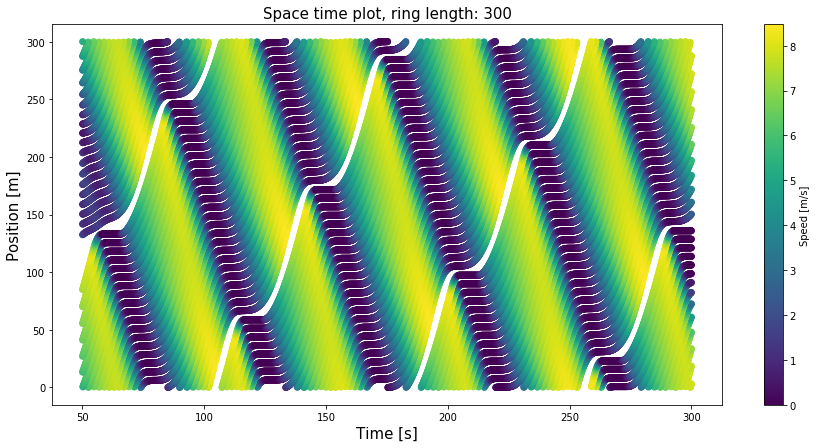

In [11]:
emission_location = os.path.join(os.getcwd(),sim_res_list_with_attack[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_location)

We can also view other quantities in terms of the traffic flow. The get_sim_timeseries() method returns timeseries data on a number of different metrics for each vehicle, which we can then use to analyze the systems performance. Let's look at energy consumption, average speed, and speed variance.

In [12]:
#Specify location of sim data:
emission_path_with_attack = os.path.join(os.getcwd(),sim_res_list_with_attack[1])
emission_path_no_attack = os.path.join(os.getcwd(),sim_res_list_no_attack[1])
#Load in timeseries for each vehicle:
timeseries_dict_with_attack = visualize_ring.get_sim_timeseries(csv_path = emission_path_with_attack)
timeseries_dict_no_attack = visualize_ring.get_sim_timeseries(csv_path = emission_path_no_attack)

Data loaded, total time: 0.7266860008239746
Data loaded, total time: 0.6820409297943115


In [13]:
#Extract speed and energy consumption under attack:
speeds_with_attack = []
energyconsumption_with_attack = []

for veh_id in timeseries_dict_with_attack:
    speed = timeseries_dict_with_attack[veh_id][:,1]
    speeds_with_attack.append(speed)
    
    energyconsumption = timeseries_dict_with_attack[veh_id][:,5]
    energyconsumption_with_attack.append(energyconsumption)

speeds_with_attack = np.array(speeds_with_attack)
energyconsumption_with_attack = np.array(energyconsumption_with_attack)

mean_speed_with_attack = np.mean(speeds_with_attack,0)
speed_std_with_attack = np.std(speeds_with_attack,0)
mean_energyconsumption_with_attack = np.mean(energyconsumption_with_attack,0)


#Extract speed and energy consumption no attack:
speeds_no_attack = []
energyconsumption_no_attack = []

for veh_id in timeseries_dict_no_attack:
    speed = timeseries_dict_no_attack[veh_id][:,1]
    speeds_no_attack.append(speed)
    
    energyconsumption = timeseries_dict_no_attack[veh_id][:,5]
    energyconsumption_no_attack.append(energyconsumption)

speeds_no_attack = np.array(speeds_no_attack)
energyconsumption_no_attack = np.array(energyconsumption_no_attack)

mean_speed_no_attack = np.mean(speeds_no_attack,0)
speed_std_no_attack = np.std(speeds_no_attack,0)
mean_energyconsumption_no_attack = np.mean(energyconsumption_no_attack,0)

#Plot results:

plt.figure(figsize = [15,10])
plt.subplot(3,1,1)
plt.plot(mean_speed_no_attack,linewidth=3,label='No attack')
plt.plot(mean_speed_with_attack,linewidth=3,label='With attack')
plt.legend(fontsize=20)
plt.ylabel('Mean speed [m/s]',fontsize=15)
plt.subplot(3,1,2)
plt.plot(speed_std_no_attack,linewidth=3)
plt.plot(speed_std_with_attack,linewidth=3)
plt.ylabel('Speed standard dev. [m/s]',fontsize=15)
plt.subplot(3,1,3)
plt.plot(mean_energyconsumption_no_attack,linewidth=3)
plt.plot(mean_energyconsumption_with_attack,linewidth=3)
plt.ylabel('Fuel use rate',fontsize=15)

IndexError: index 5 is out of bounds for axis 1 with size 4

While this particular adversary does not significantly impact the mean speed of the traffic flow, it does significant increase speed variance, and energy consumption.

## Bibliography:

[1] Wilson, R. E., & Ward, J. A. (2011). Car-following models: fifty years of linear stability analysis–a mathematical perspective. Transportation Planning and Technology, 34(1), 3-18.

[2] Bando, M., Hasebe, K., Nakayama, A., Shibata, A., & Sugiyama, Y. (1995). Dynamical model of traffic congestion and numerical simulation. Physical review E, 51(2), 1035.


